In [1]:
import numpy as np
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import pandas as pd
from collections import Counter
import seaborn as sns

In [2]:
taxa = ['B_cellulosilyticus_WH2', 
        'B_caccae', 
        'B_vulgatus', 
        'B_thetaiotaomicron', 
        'B_ovatus', 
        'R_obeum', 
        'B_uniformis', 
        'P_distasonis', 
        'C_scindens', 
        'C_aerofaciens', 
        'C_spiroforme', 
        'D_longicatena']

cols = ['#016bff',
        '#b91f1c',
        '#308937',
        '#ff8137',
        '#6f4fc7',
        '#d4b300',
        '#893a2b',
        '#ff6c79',
        '#16c4ff',
        '#766f41',
        '#00c800',
        '#af3261']

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'}

cols_species_map = dict(zip(taxa, cols))

In [3]:
def presence_absence(x):
    if pd.isna(x):
        return 0
    else:
        return 1
    
def drop_nan(x):
    if pd.isna(x):
        return False
    else:
        return True
    
def calculate_metabolic_proximity(table):
    J = np.zeros([len(table.columns), len(table.columns)])
    for i in range(len(table.columns)):
        for j in range(len(table.columns)):
            if i == j:
                J[i,j] = 0
            else:
                set_rep = Counter(table.iloc[:,[i,j]].sum(axis=1))
                J[i,j] = 1 - (set_rep[2]/(set_rep[1]+set_rep[2]))
    return pd.DataFrame(J, index=table.columns, columns=table.columns)

def get_added_information(table):
    J = np.zeros([len(table.columns), len(table.columns)])
    probs = table.apply(sum, axis=1) / 12
    for i in range(len(table.columns)):
        for j in range(len(table.columns)):
            if i == j:
                J[i,j] = 0
            else:
                K = table[(table.iloc[:,i] == 0) & (table.iloc[:,j] == 1)].copy().index
                J[i,j] = - np.sum(probs[K]*np.log(probs[K]))
    return pd.DataFrame(J, index=table.columns, columns=table.columns)

def get_aminoacid_metabolism(COG):
    return 'E' in COG

def get_carbohydrate_metabolism(COG):
    return 'G' in COG

# Carbohydrate metabolism

 ## Metabolic Proximity and Metabolic Added Information

In [4]:
dbCAN_sub = []
for taxon in taxa:
    cazymes = pd.read_table(f'dbCAN3/{taxon}/overview.txt', sep='\t', index_col=3)
    cazymes['Species'] = taxon
    cazymes = cazymes[cazymes['#ofTools'] >= 2].loc[:, ['Species']].copy()
    cazymes.reset_index(inplace=True)
    cazymes.drop_duplicates(subset=['dbCAN_sub'], inplace=True)
    cazymes.set_index('dbCAN_sub', inplace=True)
    cazymes.columns = [cazymes['Species'][0]]
    dbCAN_sub.append(cazymes)
dbCAN_sub = pd.concat(dbCAN_sub, axis=1)
dbCAN_sub.columns = dbCAN_sub.columns.map(pretty_names_dir)
dbCAN_sub = dbCAN_sub.applymap(presence_absence)
dbCAN_sub

,$B. cellulosilyticus$,$B. caccae$,$B. vulgatus$,$B. thetaiotaomicron$,$B. ovatus$,$R. obeum$,$B. uniformis$,$P. distasonis$,$C. scindens$,$C. aerofaciens$,$C. spiroforme$,$D. longicatena$
dbCAN_sub,,,,,,,,,,,,
GH30_e66,1,0,0,0,1,0,0,0,0,0,0,0
GH43_e327,1,0,0,1,0,0,0,0,0,0,0,0
GH3_e0,1,0,1,1,1,0,1,1,0,0,0,0
GH92_e30,1,0,0,1,1,0,1,1,0,0,0,0
GH95_e1,1,0,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
GH73_e250,0,0,0,0,0,0,0,0,0,0,0,1
GH2_e13,0,0,0,0,0,0,0,0,0,0,0,1
GH32_e38,0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
calculate_metabolic_proximity(dbCAN_sub)

,$B. cellulosilyticus$,$B. caccae$,$B. vulgatus$,$B. thetaiotaomicron$,$B. ovatus$,$R. obeum$,$B. uniformis$,$P. distasonis$,$C. scindens$,$C. aerofaciens$,$C. spiroforme$,$D. longicatena$
$B. cellulosilyticus$,0.000000,0.796715,0.701613,0.707885,0.675045,0.988713,0.739754,0.856855,0.995475,0.997674,0.993421,0.990991
$B. caccae$,0.796715,0.000000,0.746439,0.713930,0.746479,0.991736,0.798246,0.801980,0.991597,0.995575,0.992095,0.991736
$B. vulgatus$,0.701613,0.746439,0.000000,0.653396,0.639080,0.983165,0.762533,0.824022,0.996633,0.996479,0.993569,0.986577
$B. thetaiotaomicron$,0.707885,0.713930,0.653396,0.000000,0.609148,0.983914,0.797357,0.833724,0.991935,0.994444,0.992248,0.986631
$B. ovatus$,0.675045,0.746479,0.639080,0.609148,0.000000,0.987212,0.778742,0.826879,0.992288,0.997354,0.995062,0.984615
$R. obeum$,0.988713,0.991736,0.983165,0.983914,0.987212,0.000000,0.985130,0.986486,0.800000,0.927711,0.955357,0.808989
$B. uniformis$,0.739754,0.798246,0.762533,0.797357,0.778742,0.985130,0.000000,0.771160,0.992509,0.996078,0.989324,0.981343
$P. distasonis$,0.856855,0.801980,0.824022,0.833724,0.826879,0.986486,0.771160,0.000000,0.995455,0.995169,0.991453,0.981900
$C. scindens$,0.995475,0.991597,0.996633,0.991935,0.992288,0.800000,0.992509,0.995455,0.000000,0.950617,0.943925,0.725000
$C. aerofaciens$,0.997674,0.995575,0.996479,0.994444,0.997354,0.927711,0.996078,0.995169,0.950617,0.000000,0.958333,0.901235


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


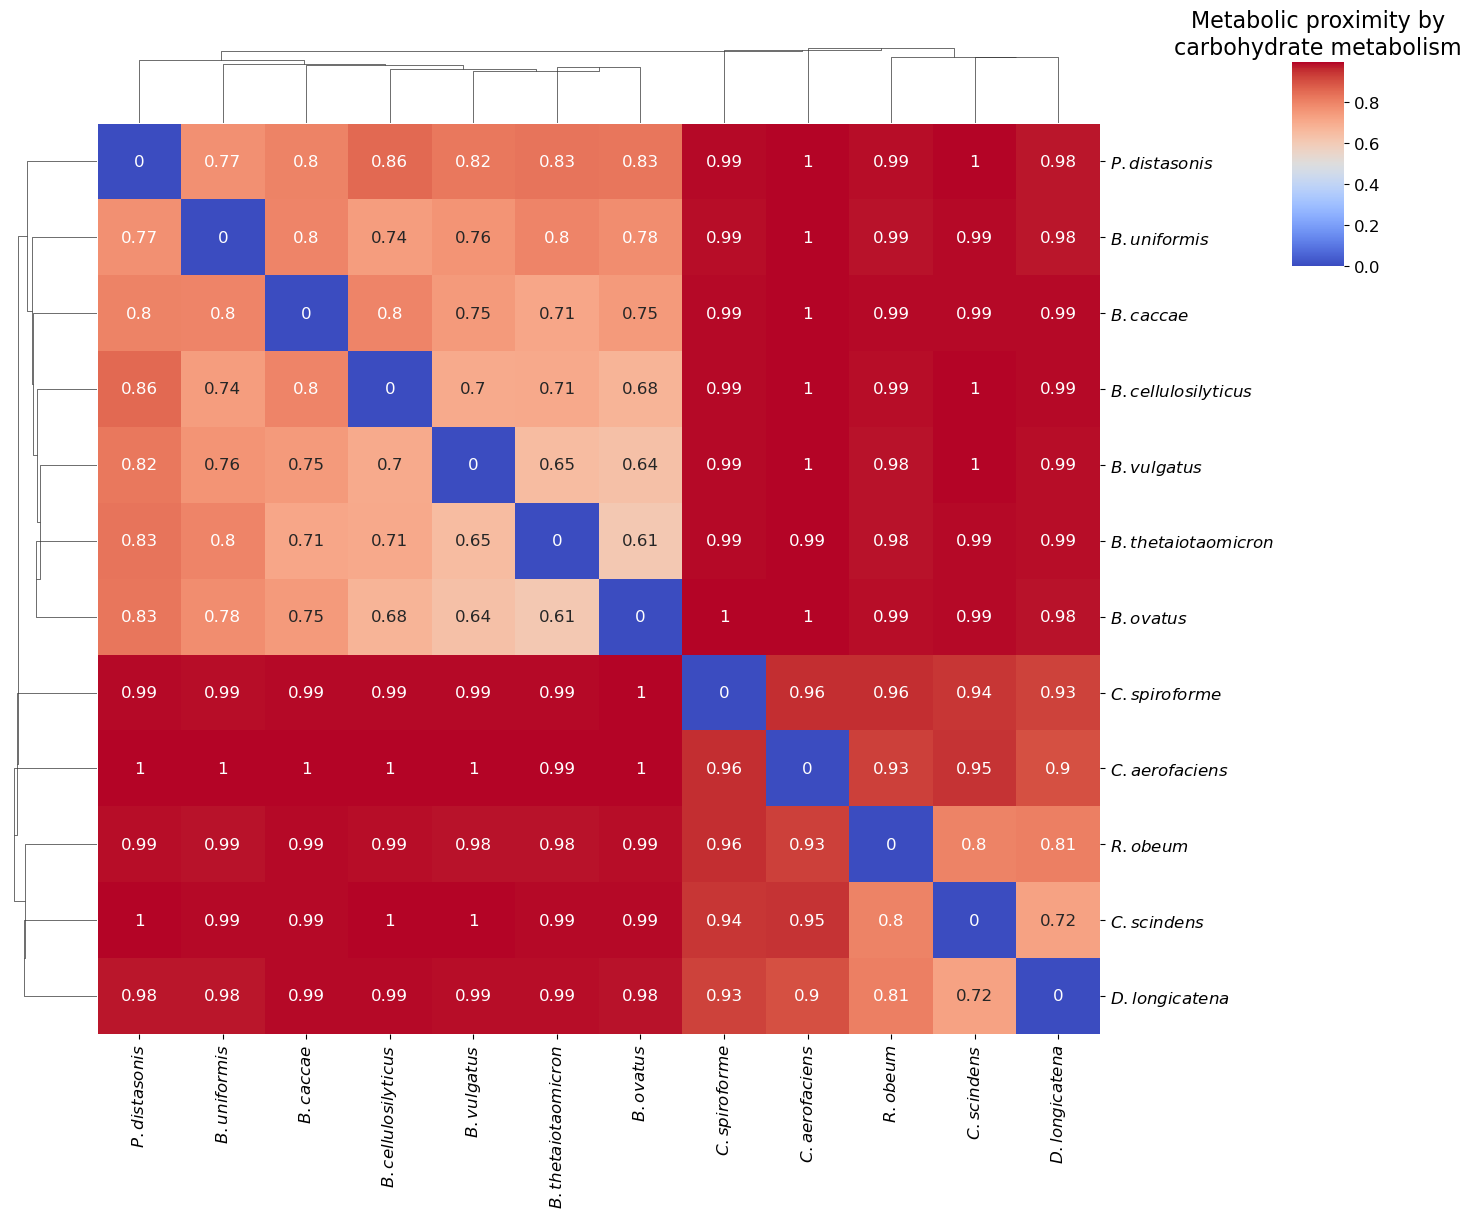

In [6]:
ax = sns.clustermap(calculate_metabolic_proximity(dbCAN_sub), 
    metric='euclidean', 
    method='centroid',
    cmap="coolwarm", 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(13, 12))
plt.title('Metabolic proximity by\ncarbohydrate metabolism', fontsize=16)
plt.show()

In [7]:
get_added_information(dbCAN_sub)

,$B. cellulosilyticus$,$B. caccae$,$B. vulgatus$,$B. thetaiotaomicron$,$B. ovatus$,$R. obeum$,$B. uniformis$,$P. distasonis$,$C. scindens$,$C. aerofaciens$,$C. spiroforme$,$D. longicatena$
$B. cellulosilyticus$,0.000000,25.593386,28.841934,43.964218,44.112402,12.702104,23.520305,26.089569,12.673787,8.301227,13.613271,13.847238
$B. caccae$,83.124195,0.000000,49.516738,61.363057,69.167268,13.778235,43.048683,29.659726,12.673787,8.301227,13.978050,14.526431
$B. vulgatus$,65.472659,28.616654,0.000000,48.787340,51.796153,12.625840,35.870966,28.631108,12.944097,8.301227,13.978050,13.770974
$B. thetaiotaomicron$,60.113786,19.981815,28.306183,0.000000,41.313515,12.355530,35.123796,26.005211,12.327214,7.954654,13.631476,13.500664
$B. ovatus$,54.402879,21.926935,25.455905,35.454423,0.000000,12.702104,31.648541,24.051406,12.327214,8.301227,13.978050,13.202038
$R. obeum$,114.549654,58.094976,77.842666,98.053513,104.259178,0.000000,64.723912,48.483277,7.589875,6.578471,12.848704,9.298678
$B. uniformis$,73.776978,35.774547,49.496915,69.230901,71.614738,13.133035,0.000000,25.424738,12.673787,8.301227,13.613271,13.482459
$P. distasonis$,92.857186,38.896535,58.768001,76.623261,80.528547,13.403345,41.935683,0.000000,12.944097,8.301227,13.927686,13.770974
$C. scindens$,115.625785,58.094976,79.265371,99.129644,104.988735,8.694322,65.369112,49.128478,0.000000,7.223671,12.550077,7.901439
$C. aerofaciens$,115.896095,58.365286,79.265371,99.399954,105.605619,12.325788,65.639422,49.128478,11.866541,0.000000,13.282486,12.476731


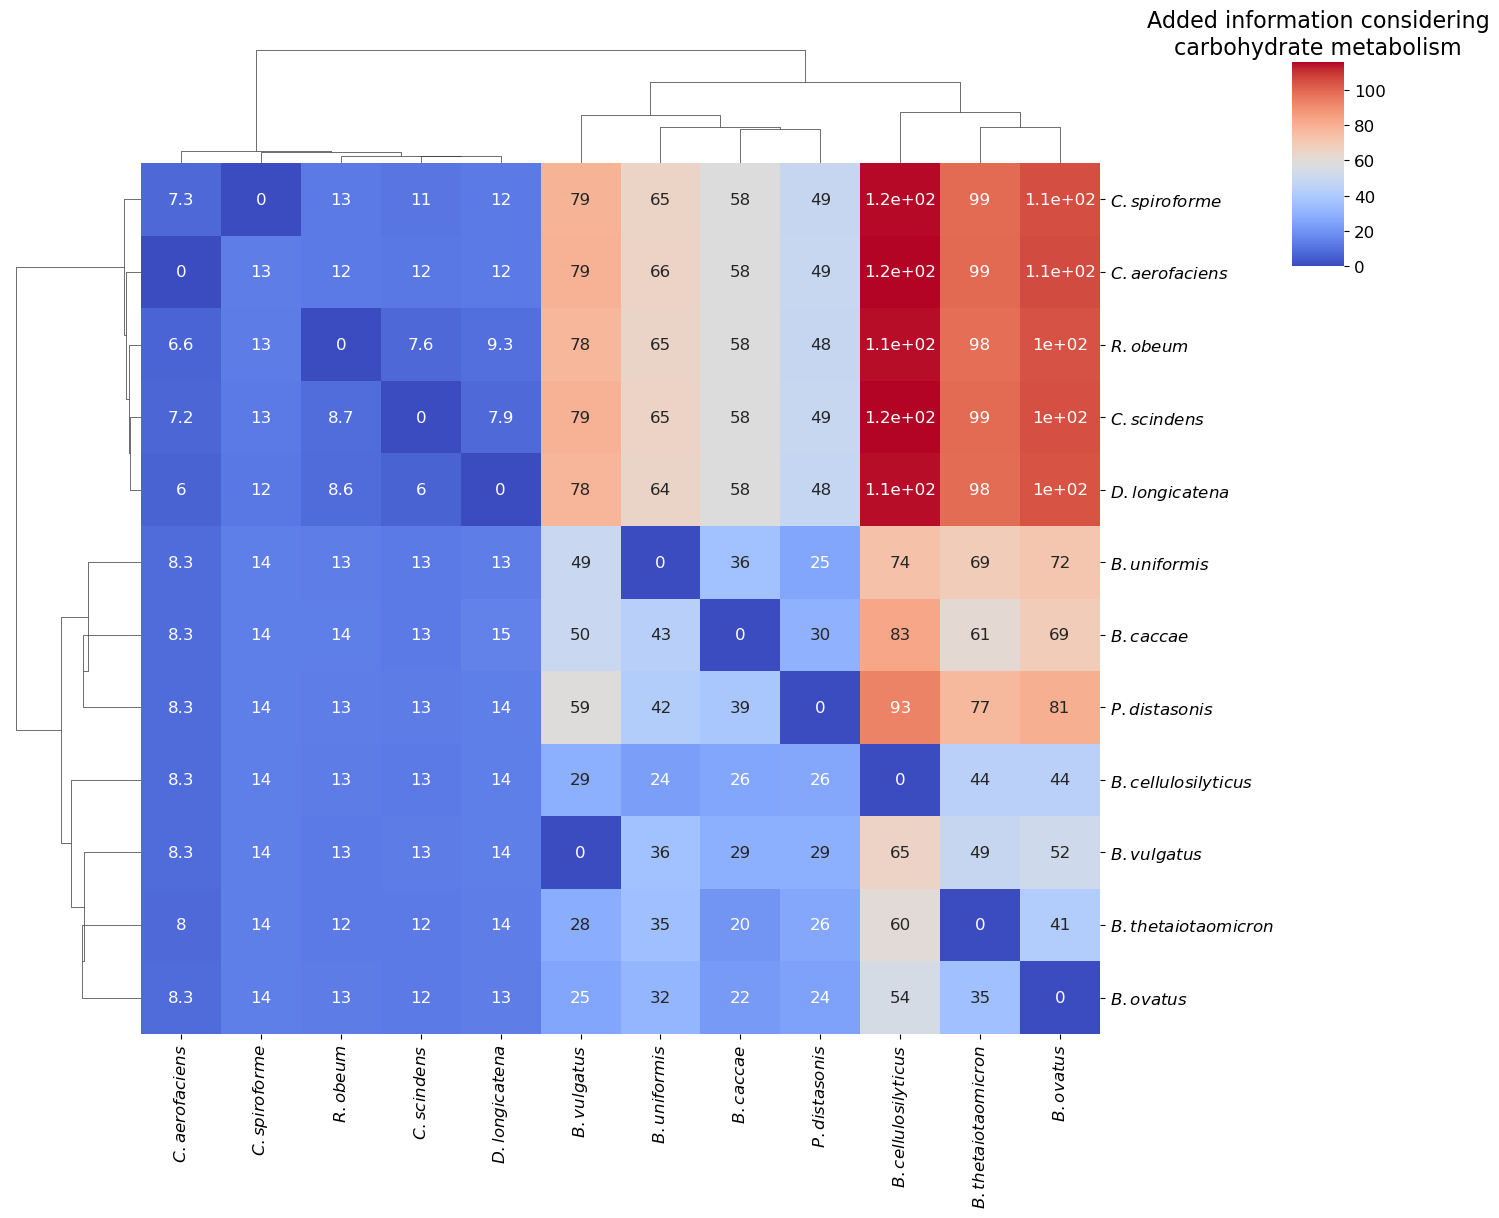

In [8]:
sns.clustermap(get_added_information(dbCAN_sub), 
    metric= 'euclidean', 
    method='centroid', 
    cmap="coolwarm", 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(13, 12), 
    row_cluster=True)
plt.title('Added information considering\ncarbohydrate metabolism', fontsize=16)
plt.show()

# Amino Acid Metabolism

 ## Metabolic Proximity and Metabolic Added Information

In [9]:
eggNOG = []
for taxon in taxa:
    aminoacid_metabolism = pd.read_table(f'eggNOG/{taxon}_eggNOG.tsv', index_col=0, skiprows=4, skipfooter=3, engine='python')
    aminoacid_metabolism['Species'] = taxon
    aminoacid_metabolism = aminoacid_metabolism[aminoacid_metabolism['COG_category'].apply(get_aminoacid_metabolism)].copy()
    aminoacid_metabolism = aminoacid_metabolism[aminoacid_metabolism['EC'] != '-'].copy()
    aminoacid_metabolism.drop_duplicates(subset=['EC'], inplace=True)
    aminoacid_metabolism.set_index('EC', inplace=True)
    aminoacid_metabolism = aminoacid_metabolism.loc[:,['Species']].copy()
    aminoacid_metabolism.columns = [aminoacid_metabolism['Species'][0]]
    eggNOG.append(aminoacid_metabolism)
eggNOG = pd.concat(eggNOG, axis=1)
eggNOG.columns = eggNOG.columns.map(pretty_names_dir)
eggNOG = eggNOG.applymap(presence_absence)
eggNOG 

,$B. cellulosilyticus$,$B. caccae$,$B. vulgatus$,$B. thetaiotaomicron$,$B. ovatus$,$R. obeum$,$B. uniformis$,$P. distasonis$,$C. scindens$,$C. aerofaciens$,$C. spiroforme$,$D. longicatena$
EC,,,,,,,,,,,,
4.3.2.1,1,1,1,1,1,1,1,1,1,1,0,1
2.7.2.11,1,1,1,1,1,0,1,1,0,1,1,0
1.2.1.41,1,1,1,1,1,1,1,1,1,1,1,0
"2.1.3.11,2.1.3.9",1,1,1,1,1,0,1,1,0,0,0,0
1.2.1.11,1,1,1,1,1,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3.7.1.22,0,0,0,0,0,0,0,0,0,0,0,1
3.4.11.5,0,0,0,0,0,0,0,0,0,0,0,1
2.7.9.3,0,0,0,0,0,0,0,0,0,0,0,1


In [10]:
calculate_metabolic_proximity(eggNOG)

,$B. cellulosilyticus$,$B. caccae$,$B. vulgatus$,$B. thetaiotaomicron$,$B. ovatus$,$R. obeum$,$B. uniformis$,$P. distasonis$,$C. scindens$,$C. aerofaciens$,$C. spiroforme$,$D. longicatena$
$B. cellulosilyticus$,0.000000,0.166667,0.181034,0.137615,0.112150,0.664234,0.154545,0.333333,0.664062,0.691729,0.900901,0.649254
$B. caccae$,0.166667,0.000000,0.172727,0.070000,0.080000,0.669231,0.144231,0.280000,0.647059,0.666667,0.891089,0.632000
$B. vulgatus$,0.181034,0.172727,0.000000,0.160714,0.169643,0.671429,0.176991,0.298507,0.661538,0.679104,0.893805,0.647059
$B. thetaiotaomicron$,0.137615,0.070000,0.160714,0.000000,0.087379,0.671642,0.132075,0.294574,0.661290,0.679688,0.896226,0.646154
$B. ovatus$,0.112150,0.080000,0.169643,0.087379,0.000000,0.679104,0.141509,0.302326,0.658537,0.677165,0.895238,0.643411
$R. obeum$,0.664234,0.669231,0.671429,0.671642,0.679104,0.000000,0.651515,0.666667,0.510204,0.539216,0.885057,0.470588
$B. uniformis$,0.154545,0.144231,0.176991,0.132075,0.141509,0.651515,0.000000,0.307692,0.639344,0.669291,0.885714,0.625000
$P. distasonis$,0.333333,0.280000,0.298507,0.294574,0.302326,0.666667,0.307692,0.000000,0.676056,0.709459,0.905512,0.662162
$C. scindens$,0.664062,0.647059,0.661538,0.661290,0.658537,0.510204,0.639344,0.676056,0.000000,0.510870,0.835616,0.285714
$C. aerofaciens$,0.691729,0.666667,0.679104,0.679688,0.677165,0.539216,0.669291,0.709459,0.510870,0.000000,0.857143,0.484536


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


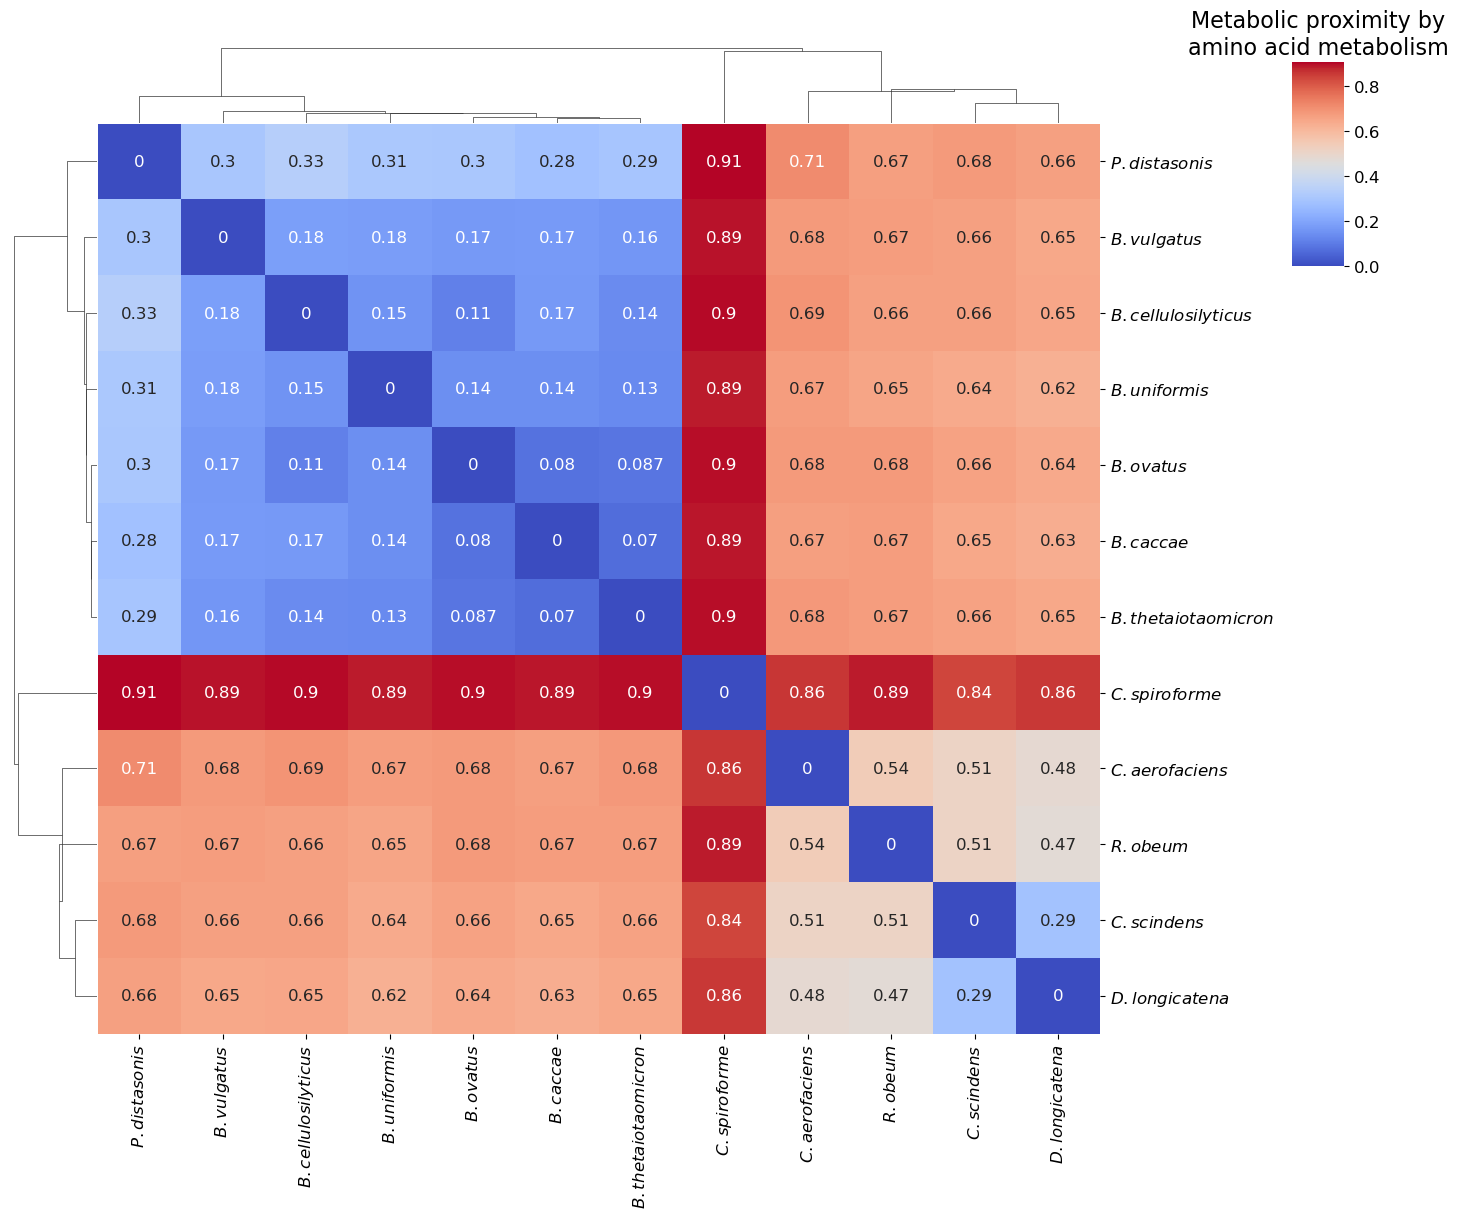

In [11]:
ax = sns.clustermap(calculate_metabolic_proximity(eggNOG), 
    metric='euclidean', 
    method='centroid',
    cmap="coolwarm", 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(13, 12))
plt.title('Metabolic proximity by\namino acid metabolism', fontsize=16)
plt.show()

In [12]:
get_added_information(eggNOG)

,$B. cellulosilyticus$,$B. caccae$,$B. vulgatus$,$B. thetaiotaomicron$,$B. ovatus$,$R. obeum$,$B. uniformis$,$P. distasonis$,$C. scindens$,$C. aerofaciens$,$C. spiroforme$,$D. longicatena$
$B. cellulosilyticus$,0.000000,1.461965,3.730186,1.694440,1.095761,10.471627,1.690598,8.050456,7.969849,8.971734,2.441211,9.674401
$B. caccae$,4.296797,0.000000,4.999964,2.022809,2.070756,11.431242,3.046158,7.942626,8.284264,8.971734,2.441211,9.988815
$B. vulgatus$,2.449396,0.884343,0.000000,1.549173,1.529543,10.210836,1.529543,6.542960,7.442591,8.164054,2.126796,9.147142
$B. thetaiotaomicron$,2.871242,0.364779,4.006765,0.000000,1.356552,11.084669,2.052959,7.614257,8.284264,8.971734,2.441211,9.988815
$B. ovatus$,2.592246,0.732408,4.306817,1.676235,0.000000,11.431242,2.333381,7.981887,8.284264,8.971734,2.441211,9.988815
$R. obeum$,16.366166,14.490949,17.386165,15.802406,15.829297,0.000000,14.749323,18.701964,4.091062,5.184431,2.052525,5.074150
$B. uniformis$,3.307440,1.828170,4.427175,2.493000,2.453739,10.471627,0.000000,8.084040,7.655435,8.657320,2.126796,9.359986
$P. distasonis$,4.270898,1.328236,4.044192,2.657897,2.705844,9.027867,2.687639,0.000000,6.828558,8.310746,2.126796,8.533109
$C. scindens$,17.646081,15.125664,18.399612,16.783694,16.464011,7.872755,15.714824,20.284348,0.000000,6.144822,1.368156,3.973237
$C. aerofaciens$,17.930228,15.095396,18.403337,16.753426,16.433744,8.248386,15.998971,21.048798,5.427084,0.000000,1.606706,6.562106


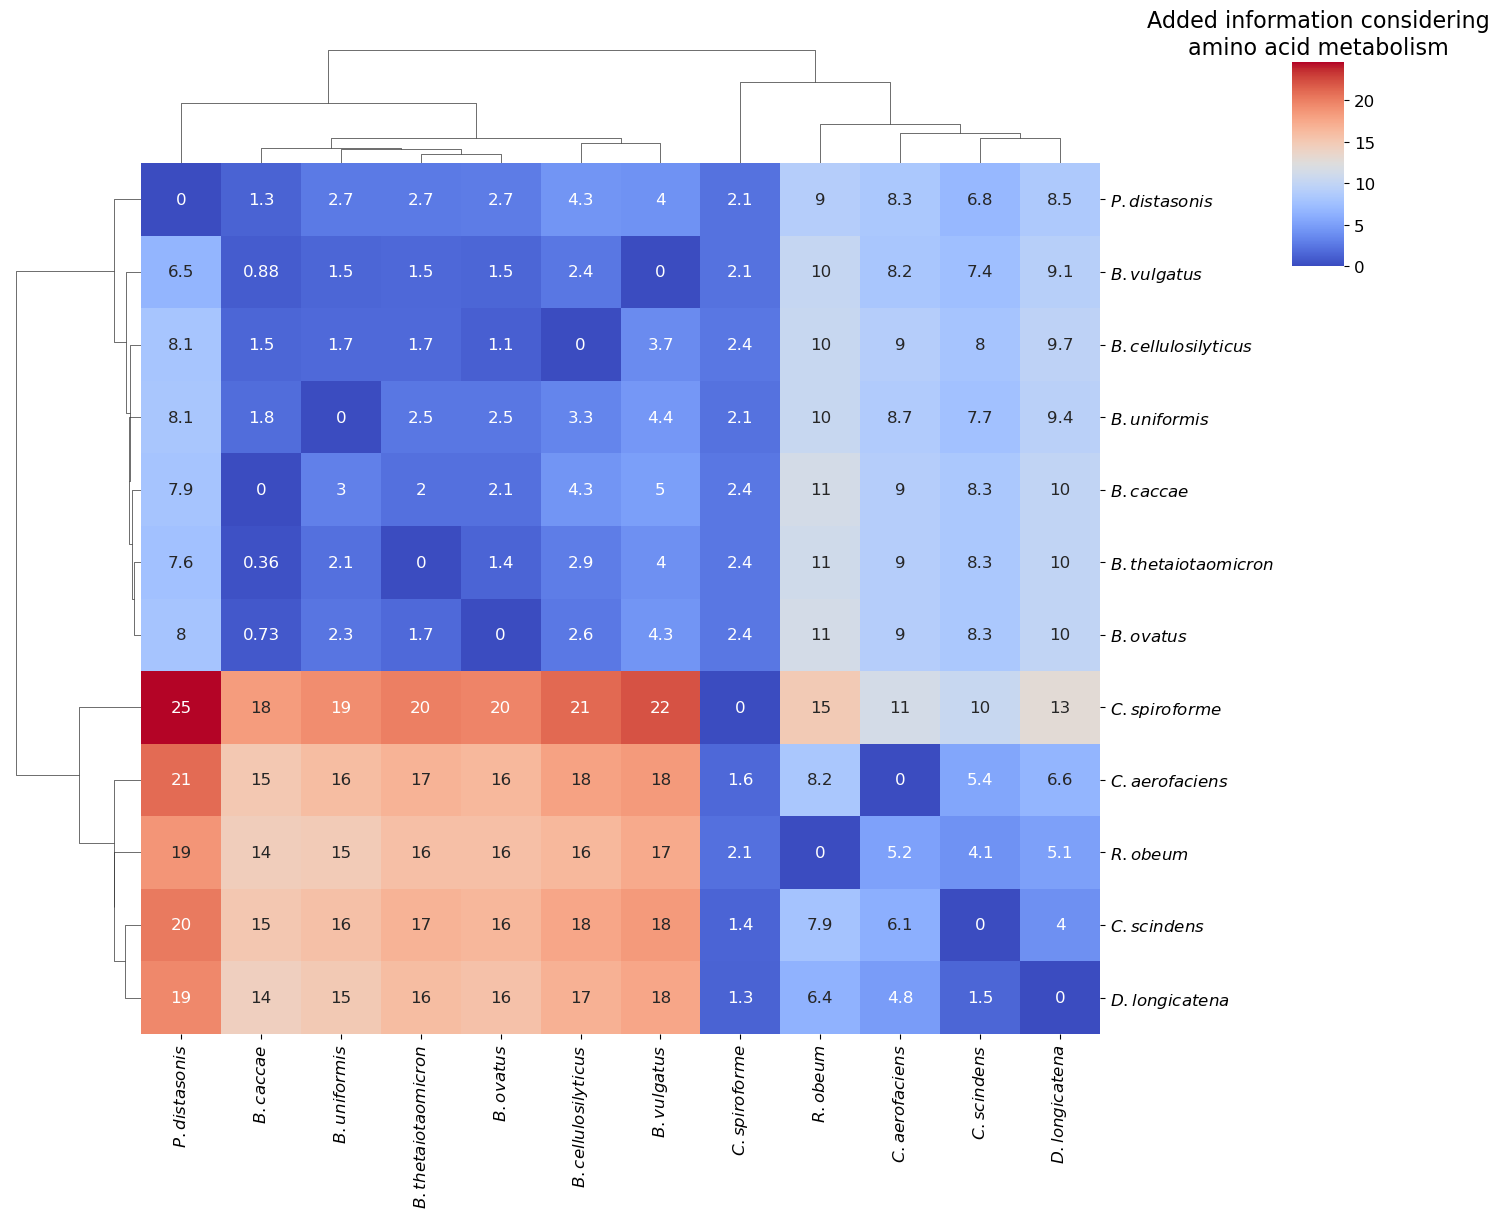

In [13]:
sns.clustermap(get_added_information(eggNOG), 
    metric= 'euclidean', 
    method='centroid', 
    cmap="coolwarm", 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(13, 12), 
    row_cluster=True)
plt.title('Added information considering\namino acid metabolism', fontsize=16)
plt.show()

# Carbohydrate and Amino Acid Metabolism

 ## Metabolic Proximity and Metabolic Added Information

In [14]:
dbCAN_sub_eggNOG = pd.concat([dbCAN_sub, eggNOG], axis=0)
dbCAN_sub_eggNOG

,$B. cellulosilyticus$,$B. caccae$,$B. vulgatus$,$B. thetaiotaomicron$,$B. ovatus$,$R. obeum$,$B. uniformis$,$P. distasonis$,$C. scindens$,$C. aerofaciens$,$C. spiroforme$,$D. longicatena$
GH30_e66,1,0,0,0,1,0,0,0,0,0,0,0
GH43_e327,1,0,0,1,0,0,0,0,0,0,0,0
GH3_e0,1,0,1,1,1,0,1,1,0,0,0,0
GH92_e30,1,0,0,1,1,0,1,1,0,0,0,0
GH95_e1,1,0,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3.7.1.22,0,0,0,0,0,0,0,0,0,0,0,1
3.4.11.5,0,0,0,0,0,0,0,0,0,0,0,1
2.7.9.3,0,0,0,0,0,0,0,0,0,0,0,1
1.21.4.1,0,0,0,0,0,0,0,0,0,0,0,1


In [15]:
calculate_metabolic_proximity(dbCAN_sub_eggNOG)

,$B. cellulosilyticus$,$B. caccae$,$B. vulgatus$,$B. thetaiotaomicron$,$B. ovatus$,$R. obeum$,$B. uniformis$,$P. distasonis$,$C. scindens$,$C. aerofaciens$,$C. spiroforme$,$D. longicatena$
$B. cellulosilyticus$,0.000000,0.682353,0.602941,0.614693,0.584337,0.912069,0.632107,0.744849,0.921053,0.925400,0.975309,0.911765
$B. caccae$,0.682353,0.000000,0.609544,0.585657,0.619772,0.879032,0.645740,0.649533,0.876751,0.879656,0.963277,0.869210
$B. vulgatus$,0.602941,0.609544,0.000000,0.551020,0.542962,0.883295,0.628049,0.680894,0.894614,0.894737,0.966981,0.880184
$B. thetaiotaomicron$,0.614693,0.585657,0.551020,0.000000,0.517123,0.901381,0.671429,0.708633,0.909274,0.911885,0.971602,0.898810
$B. ovatus$,0.584337,0.619772,0.542962,0.517123,0.000000,0.908571,0.659612,0.707746,0.912109,0.916832,0.974510,0.899807
$R. obeum$,0.912069,0.879032,0.883295,0.901381,0.908571,0.000000,0.875312,0.857527,0.644809,0.713514,0.924623,0.628272
$B. uniformis$,0.632107,0.645740,0.628049,0.671429,0.659612,0.875312,0.000000,0.636971,0.881748,0.887435,0.961140,0.866162
$P. distasonis$,0.744849,0.649533,0.680894,0.708633,0.707746,0.857527,0.636971,0.000000,0.870166,0.876056,0.961219,0.853659
$C. scindens$,0.921053,0.876751,0.894614,0.909274,0.912109,0.644809,0.881748,0.870166,0.000000,0.716763,0.900000,0.500000
$C. aerofaciens$,0.925400,0.879656,0.894737,0.911885,0.916832,0.713514,0.887435,0.876056,0.716763,0.000000,0.913295,0.674157


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


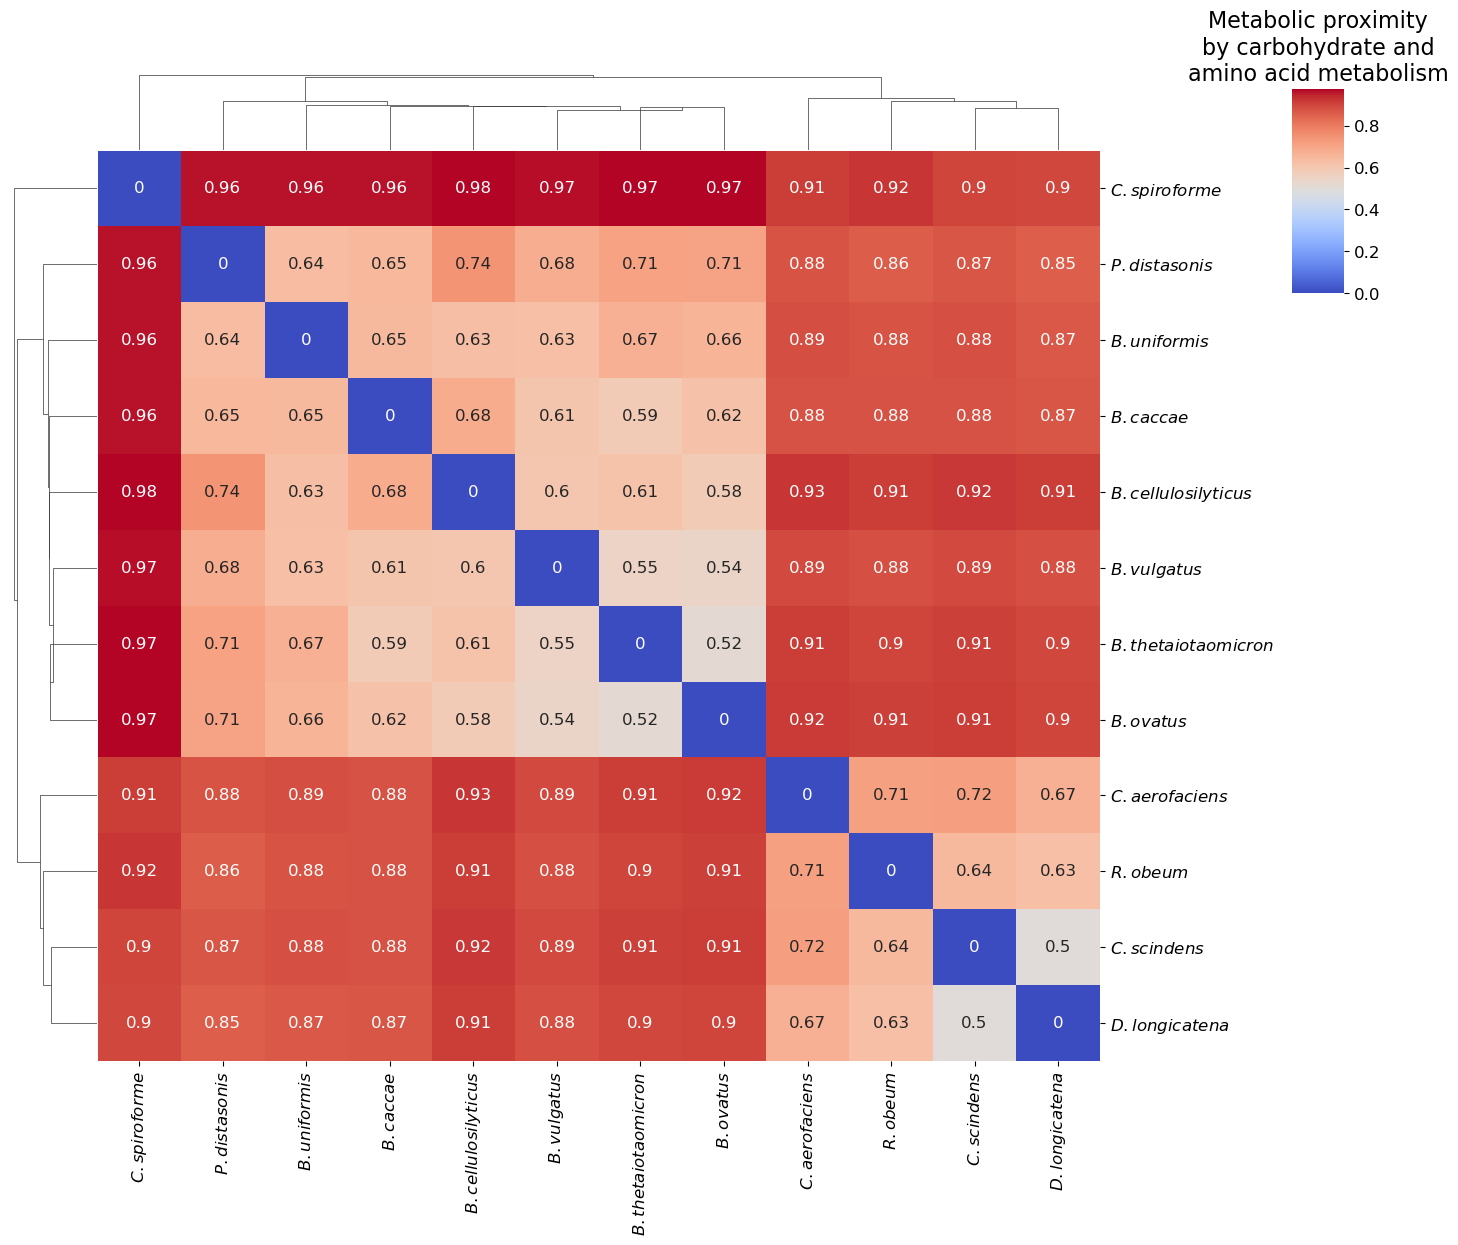

In [16]:
ax = sns.clustermap(calculate_metabolic_proximity(dbCAN_sub_eggNOG), 
    metric='euclidean', 
    method='centroid',
    cmap="coolwarm", 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(13, 12))
plt.title('Metabolic proximity\nby carbohydrate and\namino acid metabolism', fontsize=16)
plt.show()

In [17]:
get_added_information(dbCAN_sub_eggNOG)

,$B. cellulosilyticus$,$B. caccae$,$B. vulgatus$,$B. thetaiotaomicron$,$B. ovatus$,$R. obeum$,$B. uniformis$,$P. distasonis$,$C. scindens$,$C. aerofaciens$,$C. spiroforme$,$D. longicatena$
$B. cellulosilyticus$,0.000000,27.055351,32.572120,45.658658,45.208164,23.173731,25.210902,34.140024,20.643637,17.272962,16.054482,23.521638
$B. caccae$,87.420992,0.000000,54.516702,63.385865,71.238023,25.209477,46.094841,37.602352,20.958051,17.272962,16.419261,24.515246
$B. vulgatus$,67.922055,29.500997,0.000000,50.336513,53.325696,22.836677,37.400509,35.174069,20.386688,16.465282,16.104846,22.918116
$B. thetaiotaomicron$,62.985028,20.346594,32.312948,0.000000,42.670067,23.440199,37.176756,33.619469,20.611478,16.926388,16.072687,23.489479
$B. ovatus$,56.995125,22.659343,29.762722,37.130658,0.000000,24.133346,33.981922,32.033293,20.611478,17.272962,16.419261,23.190853
$R. obeum$,130.915821,72.585925,95.228831,113.855918,120.088475,0.000000,79.473235,67.185241,11.680937,11.762902,14.901229,14.372827
$B. uniformis$,77.084418,37.602716,53.924090,71.723902,74.068477,23.604662,0.000000,33.508778,20.329222,16.958547,15.740067,22.842445
$P. distasonis$,97.128084,40.224770,62.812193,79.281159,83.234391,22.431212,44.623322,0.000000,19.772655,16.611973,16.054482,22.304084
$C. scindens$,133.271866,73.220640,97.664983,115.913338,121.452747,16.567077,81.083936,69.412825,0.000000,13.368493,13.918233,11.874676
$C. aerofaciens$,133.826323,73.460682,97.668708,116.153380,122.039363,20.574175,81.638393,70.177275,17.293625,0.000000,14.889192,19.038838


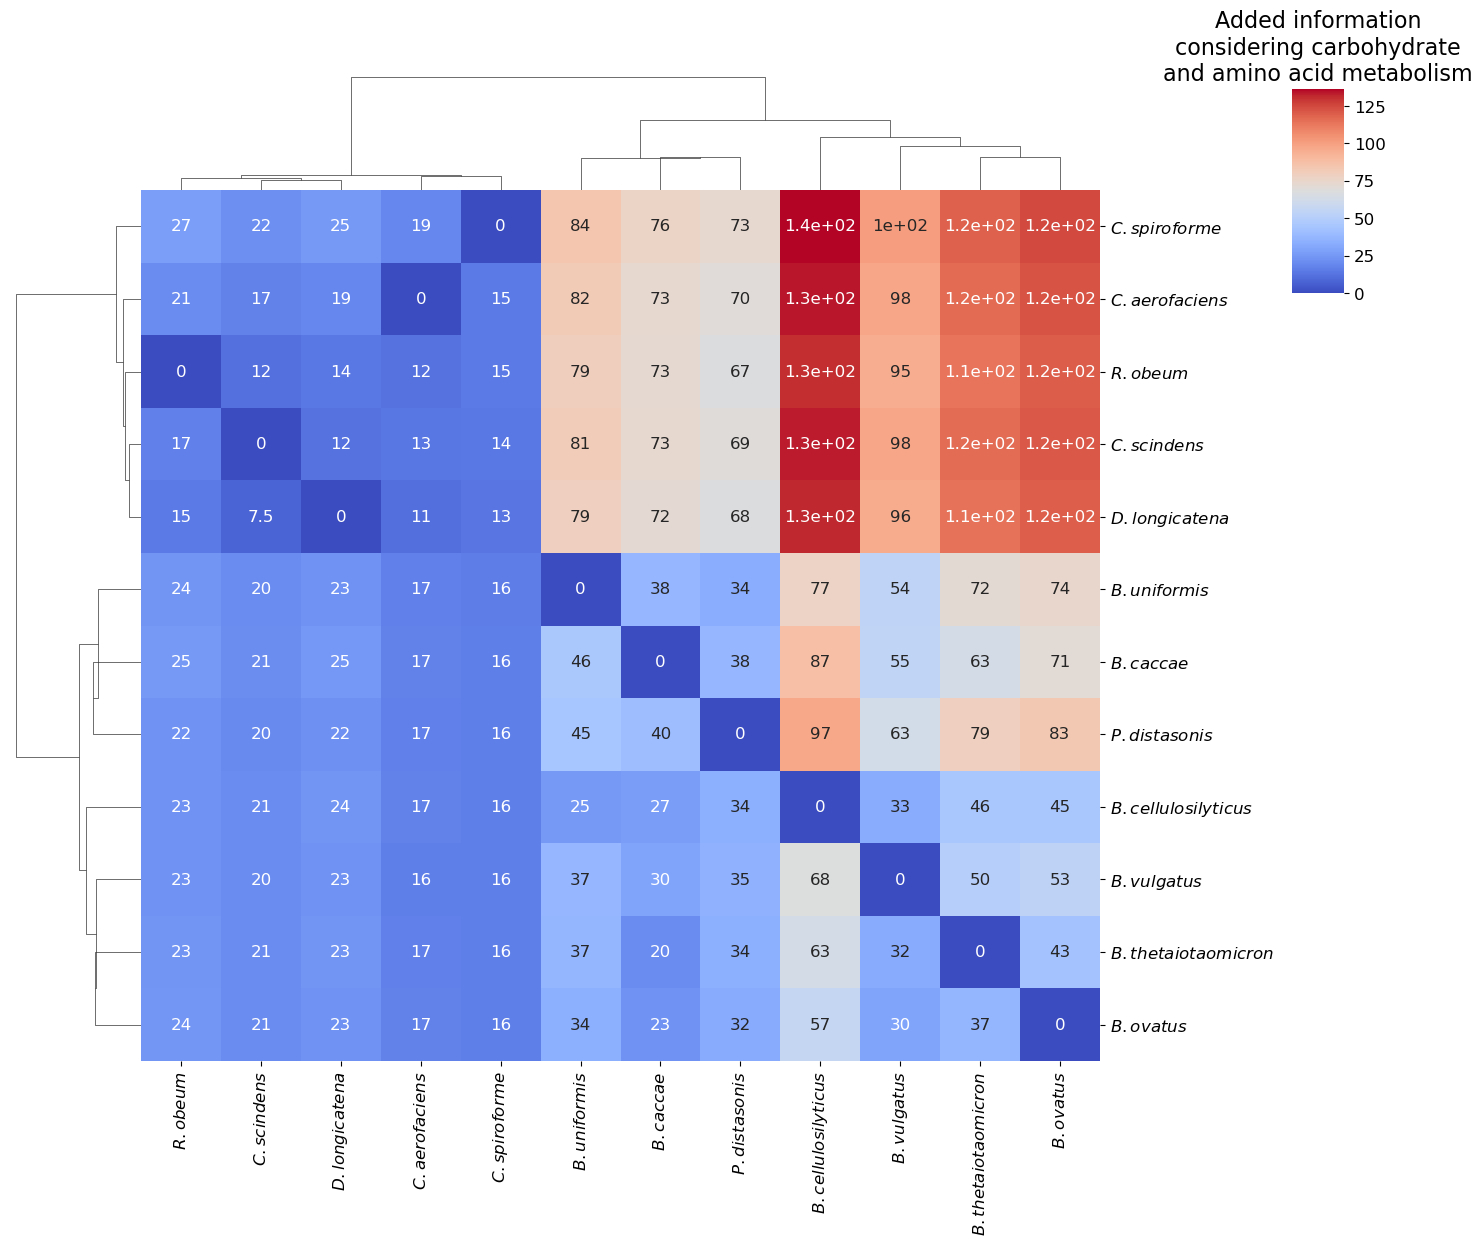

In [18]:
sns.clustermap(get_added_information(dbCAN_sub_eggNOG), 
    metric= 'euclidean', 
    method='centroid', 
    cmap="coolwarm", 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(13, 12), 
    row_cluster=True)
plt.title('Added information\nconsidering carbohydrate\nand amino acid metabolism', fontsize=16)
plt.show()